In [510]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Reading the data

In [2]:
data  = pd.read_csv('Datasets/Breast_Cancer.csv')

# EDA & Feature Engineering

In [3]:
#@ analysis of numerical variables
data.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


In [4]:
#@ analysis of categorical variables
data.describe(include='object')

,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Estrogen Status,Progesterone Status,Status
count,4024,4024,4024,4024,4024,4024,4024,4024,4024,4024,4024
unique,3,5,4,3,5,4,4,2,2,2,2
top,White,Married,T2,N1,IIA,Moderately differentiated,2,Regional,Positive,Positive,Alive
freq,3413,2643,1786,2732,1305,2351,2351,3932,3755,3326,3408


In [5]:
#@ checking for missing values
data.isna().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [5]:
#@ target variable distribution
target_class = data['Status']
target_class.value_counts(normalize=True)

Status
Alive    0.846918
Dead     0.153082
Name: proportion, dtype: float64

#@ data appears to be imbalanced

In [93]:
#@ data cleaning

df = data.copy()
df = df.rename(columns={'Reginol Node Positive':'regional_node_positive'})
df.columns = df.columns.str.lower().str.strip(' ').str.replace(' ', '_')

categorical = list(df.dtypes[df.dtypes=='object'].index)

for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
df['status'] = (df['status']=='dead').astype(int)

categorical.remove('status')
numerical = list(df.dtypes[df.dtypes!='object'].index)

In [94]:
#@ splitting the data 60:20:20

y = df['status'].values
df_full, df_test, y_full, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_full, y_full, test_size=0.25, stratify=y_full, random_state=1)

df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_full = df_full.reset_index(drop=True)

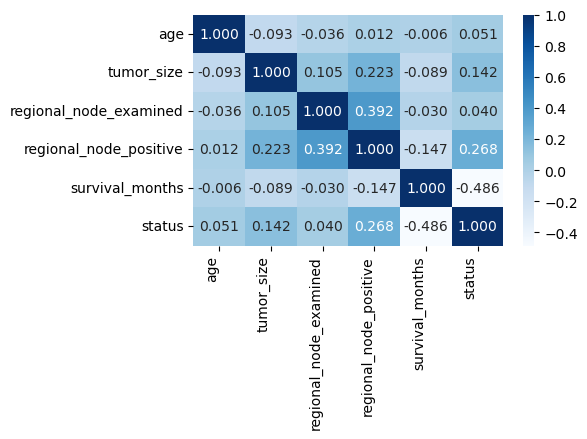

In [43]:
#@ correlation between numerical variables and Status.
plt.figure(figsize=(5,3))
sns.heatmap(df_train[numerical].corr(), annot=True, fmt='.3f', cmap='Blues')
plt.xticks(rotation=90, ha='right')
plt.show()

In [18]:
#@ mutual information score between categorical variables and Status.
df_train[categorical].apply(lambda x: mutual_info_score(x, df_train['status']))

race                   0.001012
marital_status         0.001275
t_stage                0.010418
n_stage                0.031953
6th_stage              0.032629
differentiate          0.012093
grade                  0.012093
a_stage                0.003486
estrogen_status        0.012575
progesterone_status    0.010209
dtype: float64

In [44]:
size_mapping = {
    't1': 'Small',
    't2': 'Medium',
    't3': 'Medium',
    't4': 'Large'
}
    
age_group = {
    (0, 30): 'young',
    (30, 59): 'middle_aged',
    (59, 150): 'senior'
}

In [45]:
#@ Feature Engineering
def map_age_to_group(age):
    for age_range, group in age_group.items():
        if age_range[0] <= age <= age_range[1]:
            return group
    return 'unknown'

def feature_engineer(series):
# classification of patient ages
    series['age_group'] = series['age'].apply(map_age_to_group)
    
# classification of cancer sizes
    series['size_classification'] = series['t_stage'].map(size_mapping)
    
# lymph node positivity rate: extent or severity of lymph node involvement in breast cancer.
    series['lymph_node_positivity_%'] = (series['regional_node_positive'] / series['regional_node_examined'])*100
    
    return series

In [105]:
#@ base features
base_features = sorted(train_df.columns)
base_features

['6th_stage',
 'a_stage',
 'age',
 'age_group',
 'differentiate',
 'estrogen_status',
 'grade',
 'lymph_node_positivity_%',
 'marital_status',
 'n_stage',
 'progesterone_status',
 'race',
 'regional_node_examined',
 'regional_node_positive',
 'size_classification',
 'status',
 'survival_months',
 't_stage',
 'tumor_size']

In [109]:
def prepare_df(df):
    new_df = df.copy()
    new_df = feature_engineer(new_df)
    return new_df

In [110]:
train_df = prepare_df(df_train)

In [96]:
categorical = list(train_df.dtypes[train_df.dtypes=='object'].index)
numerical = list(train_df.dtypes[train_df.dtypes!='object'].index)

In [97]:
#@ correlation
train_df[numerical].corrwith(train_df['status'])

age                        0.051148
regional_node_examined     0.039822
regional_node_positive     0.268343
status                     1.000000
survival_months           -0.485525
tumor_size                 0.142207
lymph_node_positivity_%    0.241862
dtype: float64

#@ All numerical variables have a decent correlation so we keep everything.

In [98]:
#@ mutual information score between categorical variables and Status.
train_df[categorical].apply(lambda x: mutual_info_score(x, train_df['status']))

6th_stage              0.032629
a_stage                0.003486
differentiate          0.012093
estrogen_status        0.012575
grade                  0.012093
marital_status         0.001275
n_stage                0.031953
progesterone_status    0.010209
race                   0.001012
t_stage                0.010418
age_group              0.001728
size_classification    0.009754
dtype: float64

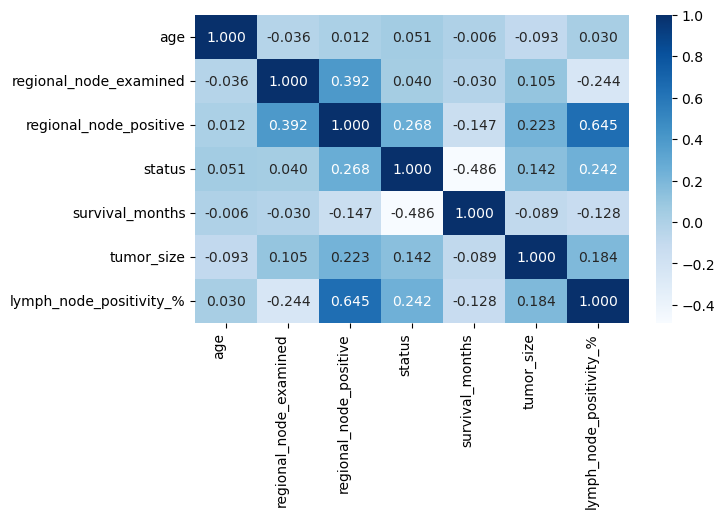

In [82]:
#@ correlation between numerical variables and Status.
plt.figure(figsize=(7,4))
sns.heatmap(train_df[numerical].corr(), annot=True, fmt='.3f', cmap='Blues')
plt.xticks(rotation=90, ha='right')
plt.show()

In [90]:
#@ Categorivcal features with low Mutual Information with Status.
low_MI = ['age_group', 'a_stage', 'race', 'marital_status']

In [471]:
#@ Defining final Datasets.
train_df = prepare_df(df_train)
val_df = prepare_df(df_val)
test_df = prepare_df(df_test)
full_df = prepare_df(df_full)

for ds in [train_df, val_df, full_df, test_df]:
    ds.drop(columns=low_MI, inplace=True)
    del ds['status']
    assert 'status' not in list(ds.columns)

In [694]:
#@ function to train model
def train_model(X, y, model):
    dv = DictVectorizer(sparse=False)
    X_dicts = X.to_dict(orient='records')
    X = dv.fit_transform(X_dicts)
    
    model.fit(X, y)
    
    return (model, dv)


#@ function to return precision and recall
def precision_recall(actual, predicted):
    conf_matrix = confusion_matrix(actual, predicted)
    tp = conf_matrix[1, 1]
    fp = conf_matrix[0, 1]
    fn = conf_matrix[1, 0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return (precision, recall)


#! function making predictions
def predict(model, dv, df):
    x_dict = df.to_dict(orient='records')
    X = dv.transform(x_dict)
    
    y_pred = model.best_estimator_.predict(X)
    
    return y_pred

# Parameter Tuning & Model Selection

In [747]:
rf = RandomForestClassifier(class_weight='balanced')
clf = XGBClassifier()

In [748]:
#@ randomforest parameters
rf_params = {
    'n_estimators': np.arange(180, 291, 20),
    'max_depth': np.arange(5, 10),
    'min_samples_leaf': np.arange(3,10)
}

#@ xgbclassifier parameters
xgb_params = {
    'n_estimators': np.arange(10, 250, 20),
    'max_depth': np.arange(3, 20, 2),
    'learning_rate': np.arange(0.1,0.6, 0.1)
    }

#@ Exhaustive Search 
rf_search = GridSearchCV(rf, rf_params, scoring='roc_auc', verbose=1, cv=5, n_jobs=-1)
xgb_search = RandomizedSearchCV(clf, xgb_params, scoring='roc_auc', verbose=1, cv=5, n_jobs=-1)

searches = {
    'Random Forest': rf_search,
    'XGBClassifer': xgb_search
}

In [740]:
#@ custom function to compare models
def compare_models(data, labels, validation_data, validation_labels, model_dict):
    results = {}
    
    for model_name, model in model_dict.items():
        fitted_model, dv = train_model(data, labels, model)
        predicted_labels = predict(fitted_model, dv, validation_data)
        precision, recall, f1, _ = precision_recall_fscore_support(validation_labels, 
                                                                   predicted_labels, average='binary')
        results[model_name] = {
            'Model': fitted_model.best_estimator_,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Roc_auc': roc_auc_score(validation_labels, predicted_labels)
        }
    
    df_results = pd.DataFrame.from_dict(results, orient='index')
    return df_results

## Model Comparison

In [752]:
#@ comparing the scores of xgbclassifier against randomforest on df_train
scores = compare_models(train_df, y_train, val_df, y_val, searches)
scores

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Model,Precision,Recall,F1 Score,Roc_auc
Random Forest,"(DecisionTreeClassifier(max_depth=7, max_featu...",0.520958,0.707317,0.600000,0.795008
XGBClassifer,"XGBClassifier(base_score=None, booster=None, c...",0.686047,0.479675,0.564593,0.720043


### Best Estimator by recall

In [755]:
best_model = scores.sort_values(by='Recall', ascending=False).iloc[0].values[0]

In [756]:
best_model

RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=7,
                       n_estimators=220)

## Training the model on full train

In [765]:
model, dv = train(full_df, y_full, best_model)

# Exporting the model

In [766]:
import pickle

In [767]:
with open('model.bin', 'wb') as f:
    pickle.dump((model, dv), f)